## Implementation of [Hierarchical Causal Models](https://arxiv.org/abs/2401.05330) (Weinstein and Blei, 2024)

In [31]:
from IPython.display import SVG

from y0.dsl import Variable
from y0.hierarchical import HCM_from_lists, augment_collapsed_model, augment_from_mechanism, collapse_HCM, subunit_graph, marginalize_augmented_model

# Figure 2 

## Confounder

Create the hierarchical causal model (HCM) in pygraphviz

Figure 2 (a)

In [2]:
confounder_hcm = HCM_from_lists(
    obs_subunits=['A', 'Y'], 
    unobs_units=['U'], 
    edges=[('U','A'), ('A','Y'), ('U','Y')])
confounder_hcm.layout("dot")
confounder_hcm.draw("./images/confounder_HCM.svg")

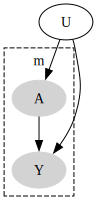

In [3]:
SVG("./images/confounder_HCM.svg")

Create the collapsed model as an NxMixedGraph  
(note that the paper displays latent variables but here we use semiMarkov graphs with latent variable connections represented by undirected edges)

Figure 2 (c)

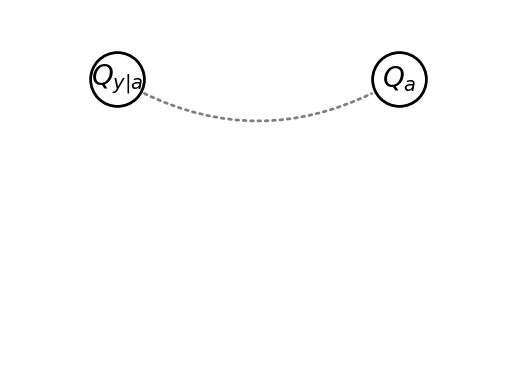

In [4]:
confounder_collapsed = collapse_HCM(confounder_hcm)
confounder_collapsed.draw()

Augment the collapsed model with new $Q_y$ variable and its mechanism $Q_y = m(Q_{y|a}, Q_a)$ from $\Pr(Y) = \Pr(Y | A) \Pr(A)$

Figure 2 (d)

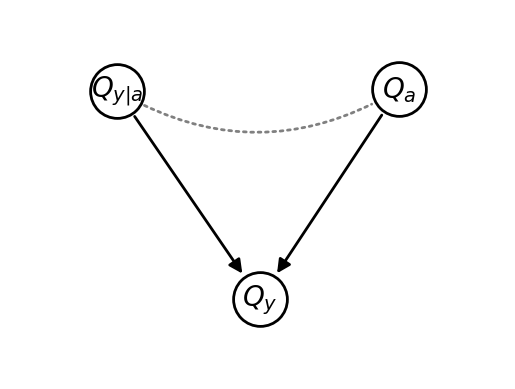

In [7]:
subg = subunit_graph(confounder_hcm)
confounder_augmented = augment_collapsed_model(
    confounder_collapsed, subg, "Y"
)
confounder_augmented.draw(prog="neato")

## Confounder and Interference

Create the HCM in pygraphviz

Figure 2 (e)

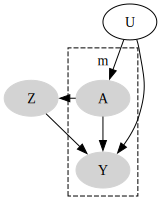

In [8]:
conf_and_int_hcm = HCM_from_lists(
    obs_subunits=['A','Y'], 
    obs_units=['Z'], 
    unobs_units=['U'], 
    edges=[('U','A'), ('A','Y'), ('U','Y'), ('A','Z'), ('Z', 'Y')]
)
conf_and_int_hcm.layout("dot")
conf_and_int_hcm.draw("./images/confounder_and_interference_HCM.svg")
SVG("./images/confounder_and_interference_HCM.svg")

Create the collapsed model as an NxMixed Graph

Figure 2 (g)

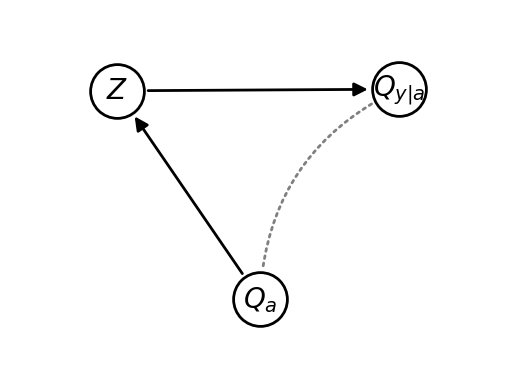

In [9]:
conf_and_int_collapsed = collapse_HCM(conf_and_int_hcm)
conf_and_int_collapsed.draw(prog="neato")

Augment the collapsed model with new variable $Q_y$ and its mechanism $Q_y = m(Q_{y|a}, Q_a)$ from $\Pr(Y) = \Pr(Y|A) \Pr(A)$

Figure 2 (h)

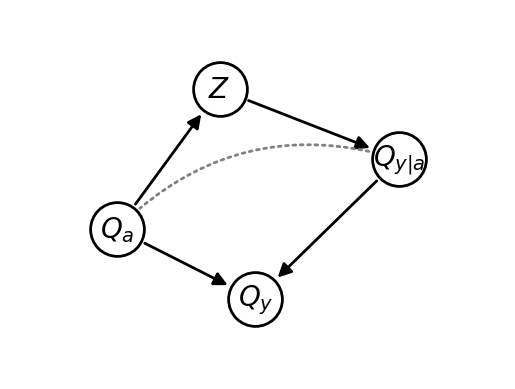

In [10]:
conf_and_int_augmented = augment_collapsed_model(
    conf_and_int_collapsed, subunit_graph(conf_and_int_hcm), "Y"
)
conf_and_int_augmented.draw(prog="dot")

## Instrument

Create the HCM in pygraphviz

Figure 2 (i)

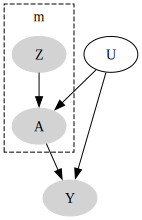

In [11]:
instrument_hcm = HCM_from_lists(
    obs_subunits=['A','Z'], 
    obs_units=['Y'], 
    unobs_units=['U'], 
    edges=[('Z','A'), ('A','Y'), ('U','Y'), ('U','A')]
)
instrument_hcm.layout("dot")
instrument_hcm.draw("./images/instrument_HCM.svg")
SVG("./images/instrument_HCM.svg")

Create the collapsed model as an NxMixedGraph

Figure 2 (k)

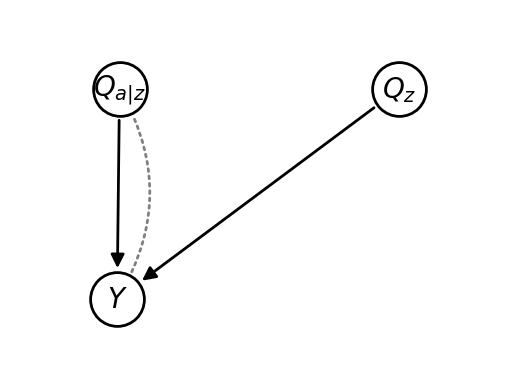

In [12]:
instrument_collapsed = collapse_HCM(instrument_hcm)
instrument_collapsed.draw()

Augment the collapsed model with new variable $Q_a$ and its mechanism $Q_a = m(Q_{a|z}, Q_z)$ from $\Pr(A) = \Pr(A|Z) \Pr(Z)$

Figure A2

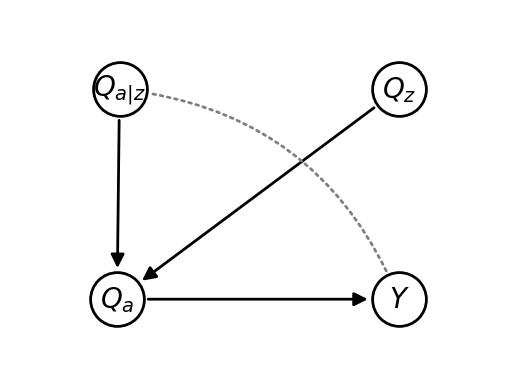

In [13]:
instrument_augmented = augment_collapsed_model(
    instrument_collapsed, subunit_graph(instrument_hcm), "A"
)
instrument_augmented.draw()

Marginalize out the $Q_z$ variable to ensure subunit positivity

Figure 2 (d)

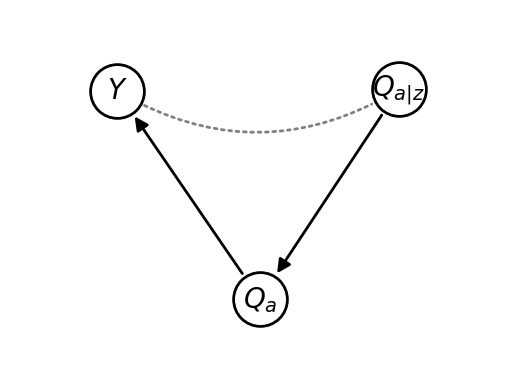

In [17]:
instrument_marg= marginalize_augmented_model(
    instrument_augmented, 
    Variable("Q_a"), 
    [Variable("Q_z")]
)
instrument_marg.draw(prog="neato")

# Figure A3

(a)

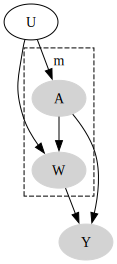

In [18]:
HCM = HCM_from_lists(obs_subunits=['A', 'W'],
                     obs_units = ['Y'],
                     unobs_units=['U'], 
                     edges=[('U','A'), ('A','Y'), ('A','W'), ('U','W'), ('W','Y')])
HCM.layout("dot")
HCM.draw("./images/A3_a.svg")
SVG("./images/A3_a.svg")

(b)

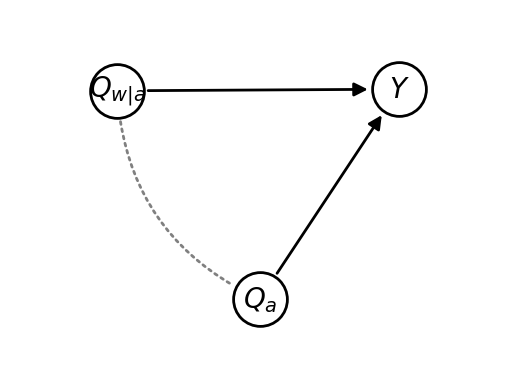

In [19]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

(c)

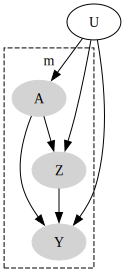

In [20]:
HCM = HCM_from_lists(obs_subunits=['A', 'Y', 'Z'],
                     unobs_units=['U'], 
                     edges=[('U','A'), ('A','Y'), ('A','Z'), ('Z','Y'), ('U','Z'), ('U','Y')])
HCM.layout("dot")
HCM.draw("./images/A3_c.svg")
SVG("./images/A3_c.svg")

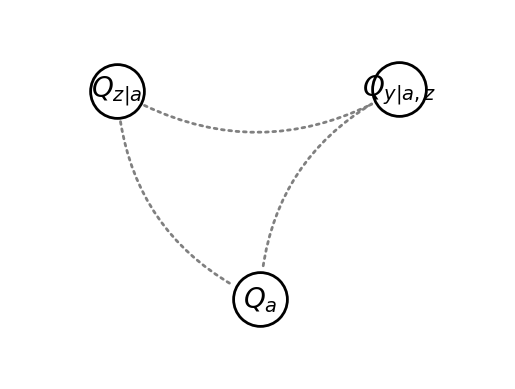

In [21]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

(d)

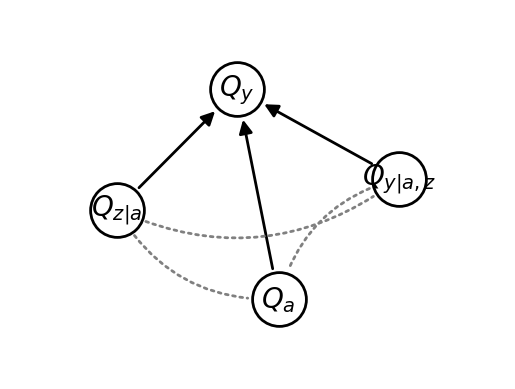

In [22]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "Y")
aug.draw(prog="neato")

(e)

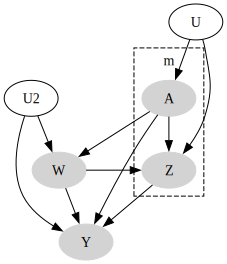

In [23]:
HCM = HCM_from_lists(obs_subunits=['A', 'Z'],
                     obs_units = ['W', 'Y'],
                     unobs_units=['U', 'U2'], 
                     edges=[('U','A'), 
                            ('U','Z'), 
                            ('A','Z'),
                            ('A','W'),
                            ('A','Y'),
                            ('W','Y'),
                            ('W','Z'),
                            ('Z','Y'),
                            ('U2','W'),
                            ('U2','Y')])
HCM.layout("dot")
HCM.draw("./images/A3_e.svg")
SVG("./images/A3_e.svg")

(f)

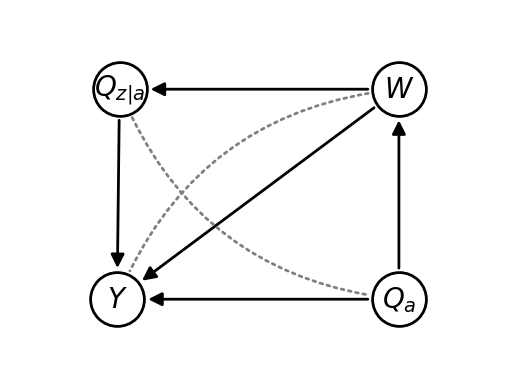

In [24]:
col = collapse_HCM(HCM)
col.draw()

(g)

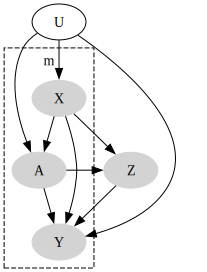

In [25]:
HCM = HCM_from_lists(obs_subunits=['A', 'X', 'Y'],
                     obs_units = ['Z'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','X'),
                            ('U','Y'),
                            ('A','Z'),
                            ('A','Y'),
                            ('Z','Y'),
                            ('X','A'),
                            ('X','Y'),
                            ('X','Z')
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A3_g.svg")
SVG("./images/A3_g.svg")

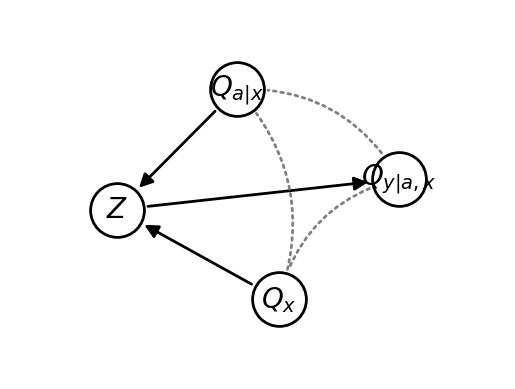

In [26]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

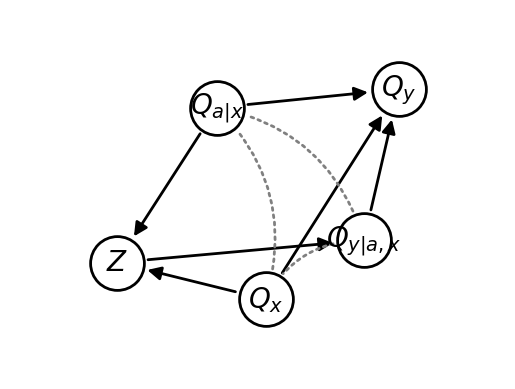

In [27]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "Y")
aug.draw(prog="neato")

(j)

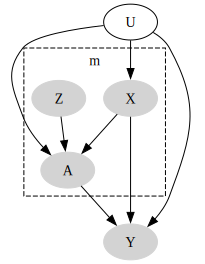

In [28]:
HCM = HCM_from_lists(obs_subunits=['A', 'X', 'Z'],
                     obs_units = ['Y'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','X'),
                            ('U','Y'),
                            ('Z','A'),
                            ('A','Y'),
                            ('X','Y'),
                            ('X','A')
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A3_j.svg")
SVG("./images/A3_j.svg")

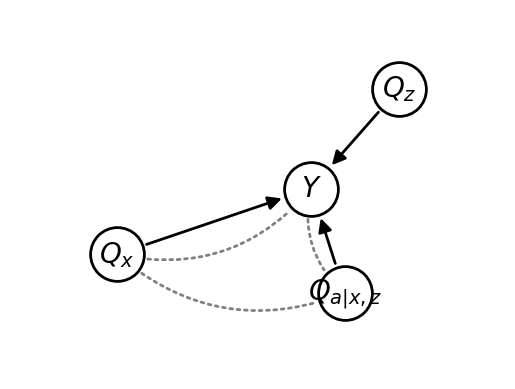

In [29]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

(k)

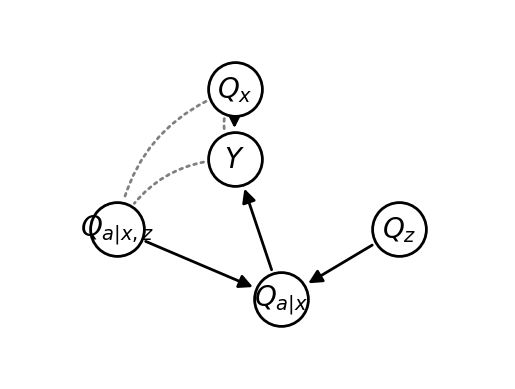

In [32]:
aug = augment_from_mechanism(col, 
                             Variable("Q_{a|x}"), 
                             [Variable("Q_z"),Variable("Q_{a|x,z}")]
                            )
aug.draw(prog="dot")

(l)

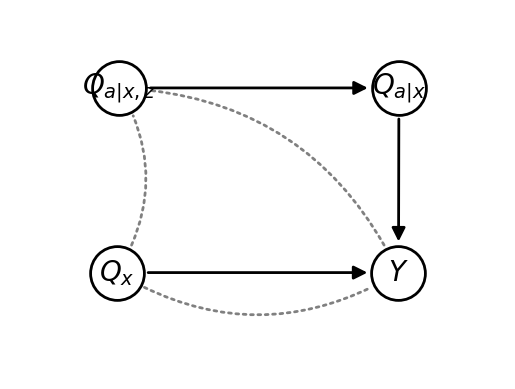

In [33]:
marg = marginalize_augmented_model(aug, Variable("Q_{a|x}"), [Variable("Q_z")])
marg.draw()

(m)

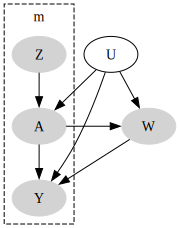

In [37]:
HCM = HCM_from_lists(obs_subunits=['A', 'Y', 'Z'],
                     obs_units = ['W'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','W'),
                            ('U','Y'),
                            ('A','W'),
                            ('A','Y'),
                            ('W','Y'),
                            ('Z','A')
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A3_m.svg")
SVG("./images/A3_m.svg")

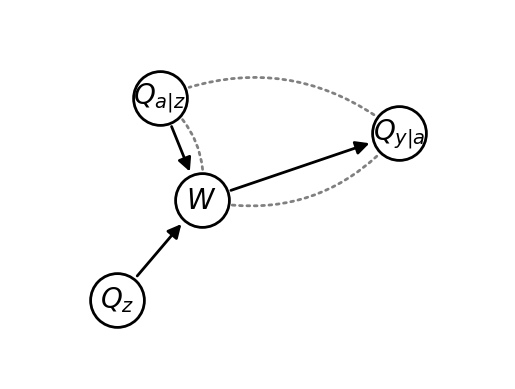

In [38]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

(n) two ways

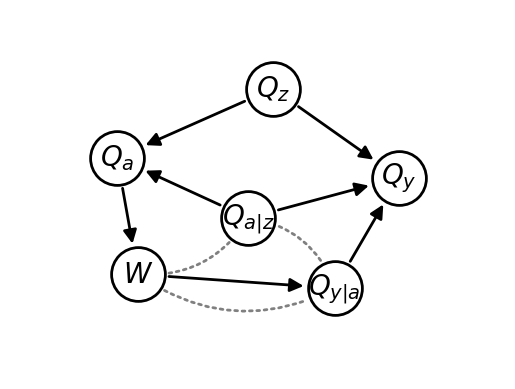

In [40]:
subg = subunit_graph(HCM)
aug1 = augment_collapsed_model(col, subg, "A")
aug2 = augment_collapsed_model(aug1, subg, "Y")
aug2.draw(prog="neato")

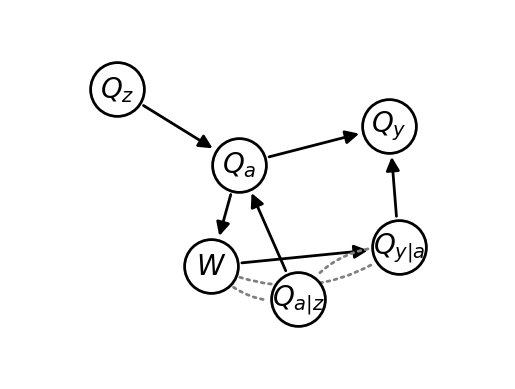

In [41]:
subg = subunit_graph(HCM)
aug1 = augment_collapsed_model(col, subg, "Y")
aug2 = augment_collapsed_model(aug1, subg, "A")
aug2.draw(prog="neato")

(o)

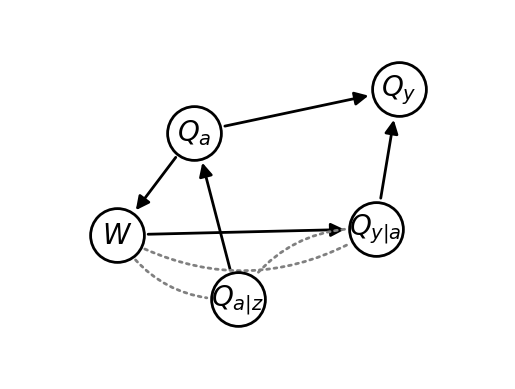

In [42]:
marg = marginalize_augmented_model(aug2, Variable("Q_a"), [Variable("Q_z")])
marg.draw(prog="neato")

(p)

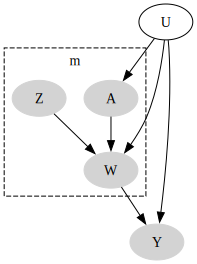

In [43]:
HCM = HCM_from_lists(obs_subunits=['A', 'W', 'Z'],
                     obs_units = ['Y'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','W'),
                            ('U','Y'),
                            ('A','W'),
                            ('Z','W'),
                            ('W','Y'),
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A3_p.svg")
SVG("./images/A3_p.svg")

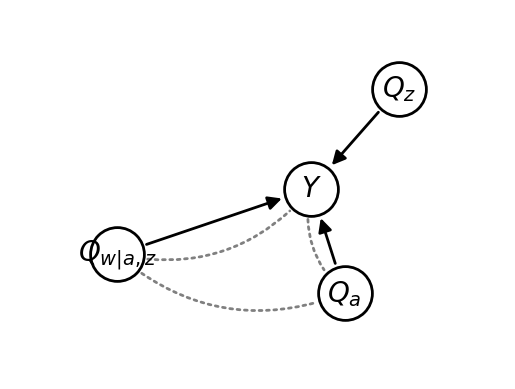

In [44]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

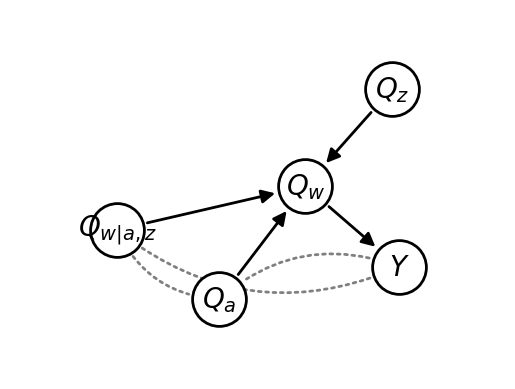

In [45]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "W")
aug.draw(prog="neato")

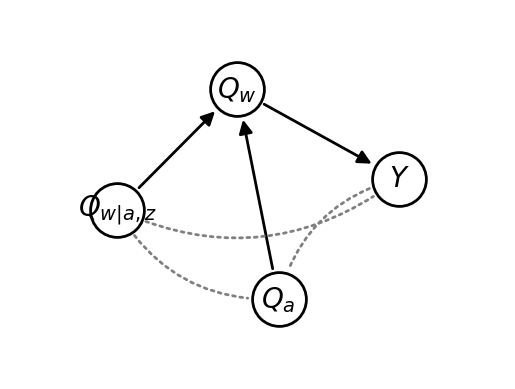

In [46]:
marg = marginalize_augmented_model(aug, Variable("Q_w"), [Variable("Q_z")])
marg.draw(prog="neato")

## Figure A4

(a)

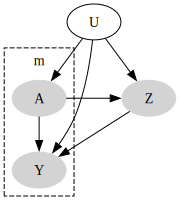

In [48]:
HCM = HCM_from_lists(obs_subunits=['A', 'Y',],
                     obs_units = ['Z'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','Z'),
                            ('U','Y'),
                            ('A','Y'),
                            ('Z','Y'),
                            ('A','Z'),
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A4_a.svg")
SVG("./images/A4_a.svg")

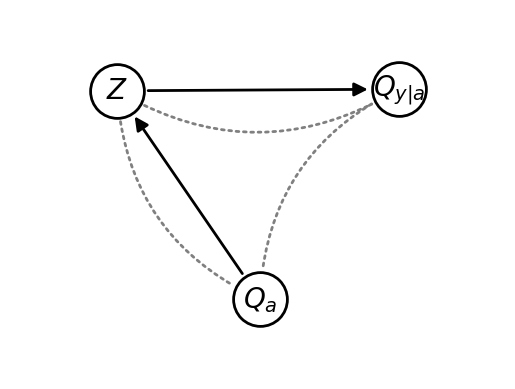

In [49]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

(b)

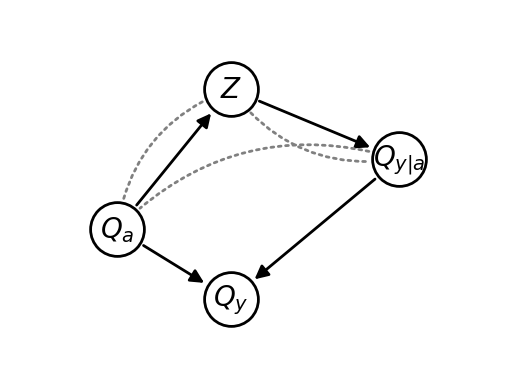

In [50]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "Y")
aug.draw(prog="dot")

(c)

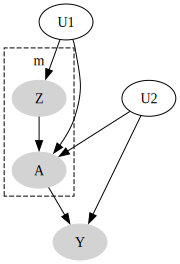

In [51]:
HCM = HCM_from_lists(obs_subunits=['A', 'Z'],
                     obs_units = ['Y'],
                     unobs_units=['U1', 'U2'], 
                     edges=[('U1','A'), 
                            ('U1','Z'),
                            ('U2','A'),
                            ('U2','Y'),
                            ('A','Y'),
                            ('Z','A'),
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A4_c.svg")
SVG("./images/A4_c.svg")

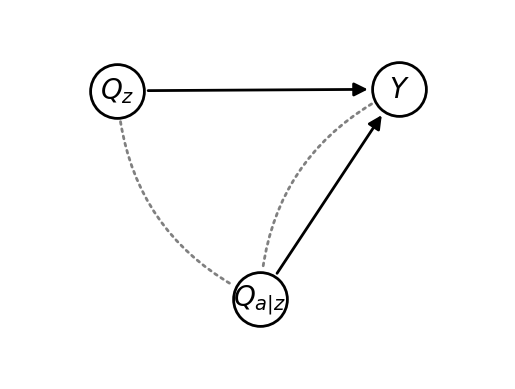

In [52]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

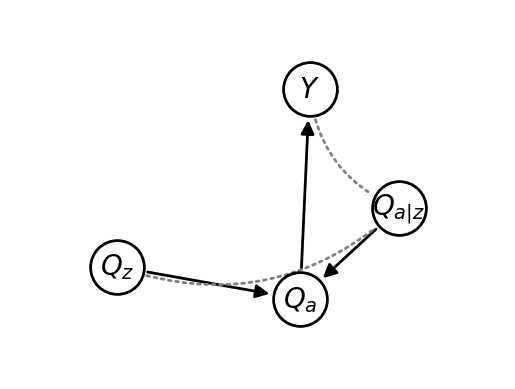

In [53]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "A")
aug.draw(prog="neato")

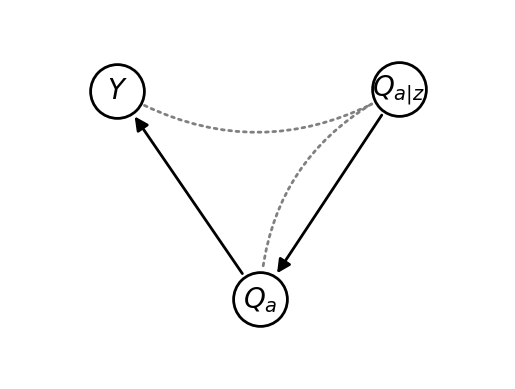

In [54]:
marg = marginalize_augmented_model(aug, Variable("Q_a"), [Variable("Q_z")])
marg.draw(prog="neato")

(f)

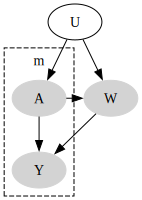

In [55]:
HCM = HCM_from_lists(obs_subunits=['A', 'Y'],
                     obs_units = ['W'],
                     unobs_units=['U'], 
                     edges=[('U','A'), 
                            ('U','W'),
                            ('A','W'),
                            ('A','Y'),
                            ('W','Y'),
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A4_f.svg")
SVG("./images/A4_f.svg")

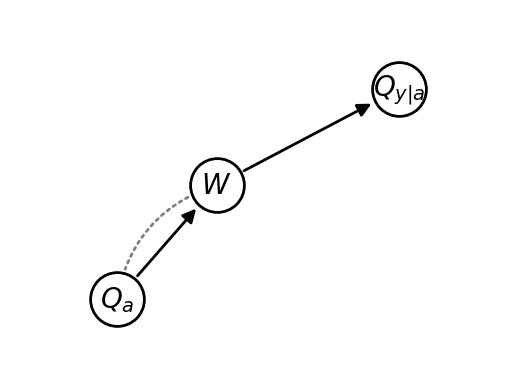

In [56]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

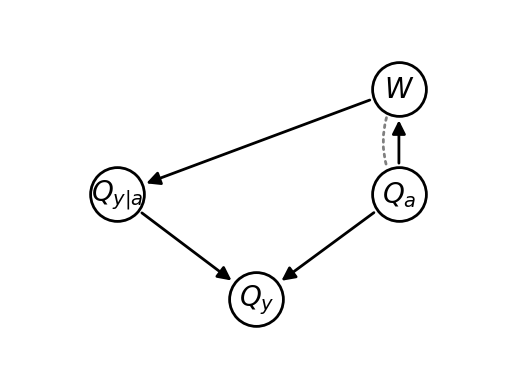

In [57]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "Y")
aug.draw(prog="dot")

(h)

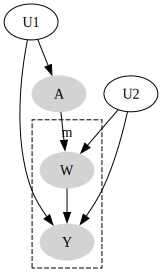

In [58]:
HCM = HCM_from_lists(obs_subunits=['W', 'Y'],
                     obs_units = ['A'],
                     unobs_units=['U1', 'U2'], 
                     edges=[('U1','A'), 
                            ('U1','Y'),
                            ('U2','W'),
                            ('U2','Y'),
                            ('A','W'),
                            ('W','Y'),
                           ]
                    )
HCM.layout("dot")
HCM.draw("./images/A4_h.svg")
SVG("./images/A4_h.svg")

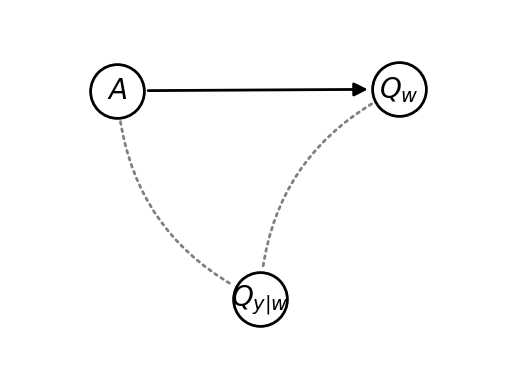

In [59]:
col = collapse_HCM(HCM)
col.draw(prog="neato")

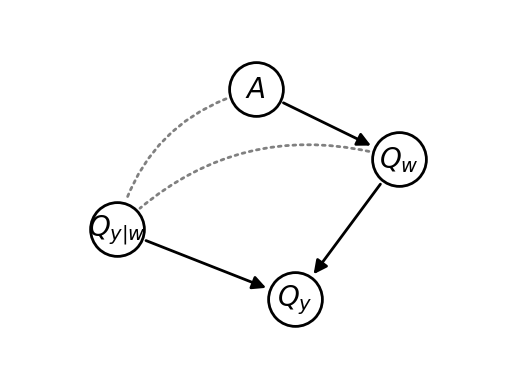

In [60]:
aug = augment_collapsed_model(col, subunit_graph(HCM), "Y")
aug.draw(prog="dot")